In [ ]:
!pip install tqdm scikit-learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.embedding = nn.Linear(128, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, 10)

    def forward(self, x, return_features=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)

        emb = F.normalize(self.embedding(x))
        logits = self.classifier(emb)

        if return_features:
            return emb, logits
        return logits

In [ ]:
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_dim, num_classes, margin=0.5, scale=30):
        super().__init__()
        self.W = nn.Parameter(torch.randn(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.W)

        self.margin = margin
        self.scale = scale

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        W = F.normalize(self.W)

        cosine = F.linear(embeddings, W)
        theta = torch.acos(torch.clamp(cosine, -1 + 1e-7, 1 - 1e-7))
        target_logits = torch.cos(theta + self.margin)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1)

        output = cosine * (1 - one_hot) + target_logits * one_hot
        output *= self.scale

        return F.cross_entropy(output, labels)

In [ ]:
def train(model, loss_fn, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        pbar = tqdm(trainloader, desc=f"Epoch [{epoch+1}/{epochs}]")

        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            if isinstance(loss_fn, ArcFaceLoss):
                emb, _ = model(x, return_features=True)
                loss = loss_fn(emb, y)
            else:
                logits = model(x)
                loss = loss_fn(logits, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        print(f"Epoch [{epoch+1}] Avg Loss: {running_loss / len(trainloader):.4f}")


In [ ]:
model_ce = SimpleCNN().to(device)
ce_loss = nn.CrossEntropyLoss()
opt_ce = torch.optim.Adam(model_ce.parameters(), lr=1e-3)

train(model_ce, ce_loss, opt_ce, epochs=10)


Epoch [1/10]: 100%|██████████| 391/391 [00:16<00:00, 24.21it/s, loss=1.5879]


Epoch [1] Avg Loss: 1.8125


Epoch [2/10]: 100%|██████████| 391/391 [00:16<00:00, 23.72it/s, loss=1.1591]


Epoch [2] Avg Loss: 1.3604


Epoch [3/10]: 100%|██████████| 391/391 [00:15<00:00, 25.75it/s, loss=1.0367]


Epoch [3] Avg Loss: 1.1415


Epoch [4/10]: 100%|██████████| 391/391 [00:15<00:00, 24.93it/s, loss=1.0094]


Epoch [4] Avg Loss: 1.0026


Epoch [5/10]: 100%|██████████| 391/391 [00:22<00:00, 17.75it/s, loss=0.8718]


Epoch [5] Avg Loss: 0.9046


Epoch [6/10]: 100%|██████████| 391/391 [00:17<00:00, 21.78it/s, loss=0.9790]


Epoch [6] Avg Loss: 0.8224


Epoch [7/10]: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s, loss=0.7224]


Epoch [7] Avg Loss: 0.7618


Epoch [8/10]: 100%|██████████| 391/391 [00:15<00:00, 26.02it/s, loss=0.5611]


Epoch [8] Avg Loss: 0.7072


Epoch [9/10]: 100%|██████████| 391/391 [00:15<00:00, 25.75it/s, loss=0.5667]


Epoch [9] Avg Loss: 0.6599


Epoch [10/10]: 100%|██████████| 391/391 [00:14<00:00, 26.26it/s, loss=0.7189]

Epoch [10] Avg Loss: 0.6141


In [ ]:
model_arc = SimpleCNN().to(device)
arc_loss = ArcFaceLoss(128, 10).to(device)

opt_arc = torch.optim.Adam(
    list(model_arc.parameters()) + list(arc_loss.parameters()),
    lr=1e-3
)

train(model_arc, arc_loss, opt_arc, epochs=10)

Epoch [1/10]: 100%|██████████| 391/391 [00:15<00:00, 25.41it/s, loss=0.2185]


Epoch [1] Avg Loss: 6.3691


Epoch [2/10]: 100%|██████████| 391/391 [00:15<00:00, 25.57it/s, loss=0.2143]


Epoch [2] Avg Loss: 0.2156


Epoch [3/10]: 100%|██████████| 391/391 [00:15<00:00, 25.90it/s, loss=0.2124]


Epoch [3] Avg Loss: 0.2132


Epoch [4/10]: 100%|██████████| 391/391 [00:15<00:00, 25.04it/s, loss=0.2126]


Epoch [4] Avg Loss: 0.2125


Epoch [5/10]: 100%|██████████| 391/391 [00:14<00:00, 26.23it/s, loss=0.2116]


Epoch [5] Avg Loss: 0.2121


Epoch [6/10]: 100%|██████████| 391/391 [00:15<00:00, 26.01it/s, loss=0.2119]


Epoch [6] Avg Loss: 0.2119


Epoch [7/10]: 100%|██████████| 391/391 [00:15<00:00, 24.88it/s, loss=0.2130]


Epoch [7] Avg Loss: 0.2122


Epoch [8/10]: 100%|██████████| 391/391 [00:15<00:00, 25.17it/s, loss=0.2114]


Epoch [8] Avg Loss: 0.2117


Epoch [9/10]: 100%|██████████| 391/391 [00:15<00:00, 26.00it/s, loss=0.2117]


Epoch [9] Avg Loss: 0.2116


Epoch [10/10]: 100%|██████████| 391/391 [00:14<00:00, 26.10it/s, loss=0.2112]

Epoch [10] Avg Loss: 0.2117


In [ ]:
def extract_features(model):
    model.eval()
    feats, labs = [], []

    with torch.no_grad():
        for x, y in tqdm(testloader, desc="Extracting Features"):
            x, y = x.to(device), y.to(device)
            emb, _ = model(x, return_features=True)

            feats.append(emb.cpu())
            labs.append(y.cpu())

    return torch.cat(feats).numpy(), torch.cat(labs).numpy()

In [ ]:
feat_ce, lab_ce = extract_features(model_ce)
feat_arc, lab_arc = extract_features(model_arc)


Extracting Features: 100%|██████████| 79/79 [00:02<00:00, 34.98it/s]


In [ ]:
def plot_tsne(features, labels, title):
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42
    )

    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(7, 6))
    for i in range(10):
        idx = labels == i
        plt.scatter(
            features_2d[idx, 0],
            features_2d[idx, 1],
            s=6,
            label=str(i)
        )

    plt.legend(markerscale=2)
    plt.title(title)
    plt.xlabel("Dim-1")
    plt.ylabel("Dim-2")
    plt.tight_layout()
    plt.show()

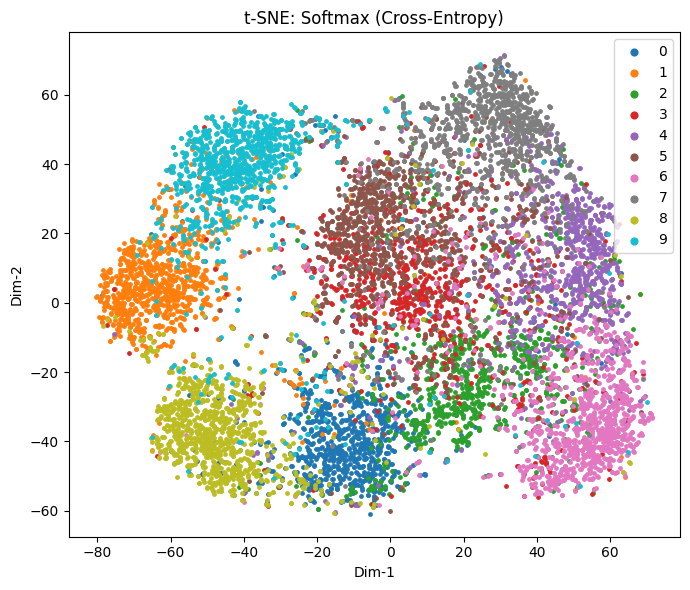

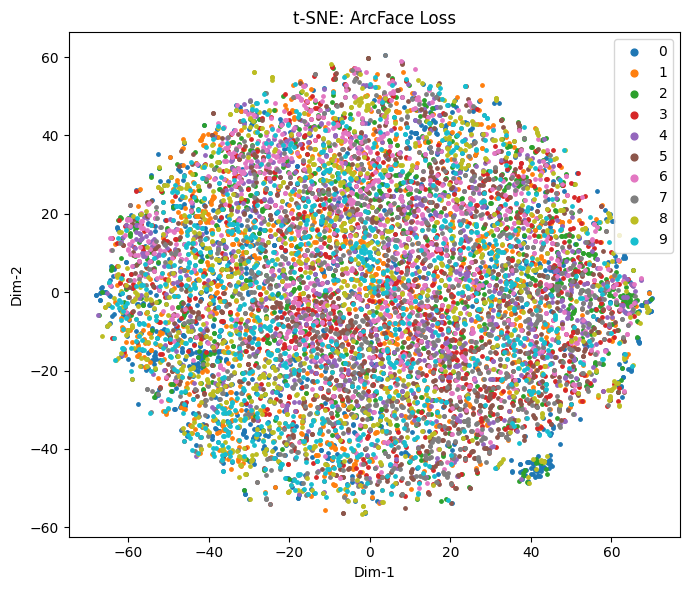

In [ ]:
plot_tsne(feat_ce, lab_ce, "t-SNE: Softmax (Cross-Entropy)")
plot_tsne(feat_arc, lab_arc, "t-SNE: ArcFace Loss")